### ToDos


Model
- [ ] Add Batch Norm to Model
- [ ] Remove Leaky ReLu
- [ ] Import Model Weights from Caffe
- [ ] __Metrics__: IoU, F1, etc.

Preprocessing
- [ ] Check Deformation (Sample Generator)
- [ ] Validation Split
- [ ] Normalize values to [0,1] range?
- [ ] Rewrite Prediction - all tiles at the same time
- [ ] Use trained model to predict

General
- [ ] Folder for Checkpoints
- [ ] Prettify Code


Import packages

In [1]:
import numpy as np
import pandas as pd
from skimage import io
import os
import Unet
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

Using TensorFlow backend.


## Global Settings

In [2]:
MASK = 'cFOS'
SUFFIX = 'gt' # '_mask'
IMAGE = 'red'
CHANNELS_IMG = 1
DATA_PATH = "01_data"
MASK_PATH = "03_masks_cc"
CODER = 'gt'
ASSIGNMENT_PATH = 'samples_36_final.csv'
VIS_SAMPLE = 3
TILE_SHAPE = (540,540)
PADDING = (184,184) # 540-356
SEED = 42
EL_SIZE = [635.9, 635.9] #micrometers

## Load Data

Excel list with assignments

In [3]:
assignment = pd.read_csv(ASSIGNMENT_PATH, converters={'Nummer': lambda x: str(x).zfill(4)})
assignment['Group_ID'] = assignment.groupby(['Genotyp', 'Kondition', 'Area', 'region']).ngroup()

file_ids = assignment['Nummer'].tolist()
file_groups = np.asarray([assignment['Group_ID'][assignment['Nummer'] == i].values[0] for i in file_ids])

Images

In [4]:
image_list = [io.imread(os.path.join(DATA_PATH, img_name), as_gray=True) for 
              img_name in [s + '_' + IMAGE + '.tif' for s in file_ids]]

Mean:  0.10396270003973268
Max:  1.0


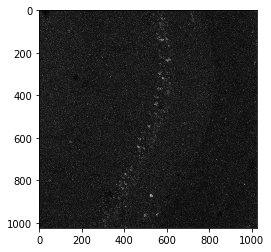

In [5]:
print('Mean: ', np.mean(image_list[VIS_SAMPLE]))
print('Max: ', np.max(image_list[VIS_SAMPLE]))
plt.imshow(image_list[3],cmap='gray')
plt.show()

Expand Dims

In [6]:
image_list = [np.expand_dims(img, axis=2) for img in image_list]

Masks

In [7]:
mask_list = [io.imread(os.path.join(MASK_PATH, CODER, x), as_gray=True).astype('int')
             for x in [s + '_' + MASK + '.tif' for s in file_ids]]

[0 1]


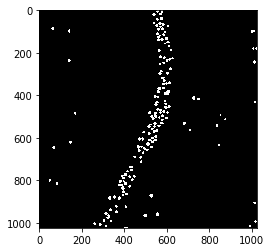

In [8]:
print(np.unique(mask_list[VIS_SAMPLE]))
plt.imshow(mask_list[VIS_SAMPLE],cmap='gray')
plt.show()

### Split Data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(image_list, mask_list, 
                                                    test_size=0.10, random_state=SEED)

In [10]:
data_train = [{'rawdata': img, 'element_size_um': EL_SIZE} 
              for img in X_train]

In [11]:
data_test = [{'rawdata': img, 'element_size_um': EL_SIZE} 
              for img in X_test]

In [33]:
train_generator = Unet.DataAugmentationGenerator(data = data_train, 
                                                  instancelabels=y_train,
                                                  tile_shape = TILE_SHAPE, 
                                                  padding= PADDING,
                                                  rotation_range_deg=(0, 90),
                                                 batch_size = 2,
                                                  flip=True, 
                                                  deformation_grid=None, 
                                                  deformation_magnitude=(0, 0),
                                                  value_minimum_range=(0, 0), 
                                                  value_maximum_range=(1, 1), 
                                                  save_to_dir = None,
                                                save_prefix = 'train', 
                                                save_format = 'png')

  3%|▎         | 1/32 [00:00<00:03,  8.49it/s]

Processing training samples


100%|██████████| 32/32 [00:03<00:00,  9.17it/s]


Generating deformation field
Generating value augmentation function


In [30]:
test_generator = Unet.DataAugmentationGenerator(data = data_test, 
                                                  instancelabels=y_test,
                                                  tile_shape = TILE_SHAPE, 
                                                  padding= PADDING)

 25%|██▌       | 1/4 [00:00<00:00,  8.96it/s]

Processing training samples


100%|██████████| 4/4 [00:00<00:00,  9.30it/s]


Generating deformation field
Generating value augmentation function


## Model

In [31]:
model = Unet.Unet2D(snapshot=None, 
                    n_channels=1, 
                    n_classes=2, 
                    n_levels=4, 
                    n_features=64, name="U-Net")

In [15]:
#model.loadCaffeModelH5('2d_cell_net_v0.caffemodel.h5')

In [16]:
model.trainModel.load_weights('2d_cell_net_v0.caffemodel.h5', by_name=True)

In [34]:
model.train(train_generator, 
            validation_generator=None, 
            n_epochs=2, 
            snapshot_interval=50, 
            snapshot_prefix='new')

Epoch 1/2
15/16 [===========================>..] - ETA: 0s - loss: 0.6351
Generating deformation field
Generating value augmentation function
16/16 [==============================] - 6s 368ms/step - loss: 0.6329
Epoch 2/2
15/16 [===========================>..] - ETA: 0s - loss: 0.4258
Generating deformation field
Generating value augmentation function
16/16 [==============================] - 4s 234ms/step - loss: 0.4897


In [18]:
pred_model = Unet.Unet2D(snapshot='new.0200.h5', 
                    n_channels=1, 
                    n_classes=2, 
                    n_levels=4, 
                    n_features=64, name="U-Net")

In [19]:
tile_generator = Unet.TileGenerator(data_test, TILE_SHAPE, PADDING)

 25%|██▌       | 1/4 [00:00<00:00,  9.84it/s]

Processing test samples


100%|██████████| 4/4 [00:00<00:00,  9.85it/s]


In [20]:
model.testModel.load_weights('2d_cell_net_v0.caffemodel.h5', by_name=True)

In [21]:
predictions = model.predict(tile_generator)

100%|██████████| 36/36 [00:01<00:00, 22.50it/s]


Mean:  0.8107051849365234
Max:  1.0


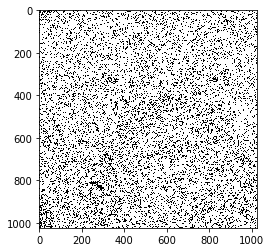

In [22]:
print('Mean: ', np.mean(predictions[1][VIS_SAMPLE]))
print('Max: ', np.max(predictions[1][VIS_SAMPLE]))
plt.imshow(predictions[1][VIS_SAMPLE],cmap='gray')
plt.show()

In [23]:
msk_comp = np.zeros((1024,1024,3))
#msk_comp[...,0] = image_list[VIS_SAMPLE][...,0]
msk_comp[...,0] = predictions[1][VIS_SAMPLE]
msk_comp[...,2] = y_test[VIS_SAMPLE]

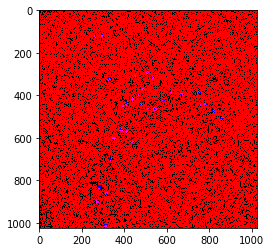

In [24]:
plt.imshow(msk_comp)
plt.show()

In [25]:
io.imsave('msk_comp.png', msk_comp)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
